In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.special import expit
from experiment_constant import *

/home/sergei/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
W1 = np.ones((4, 3))
W2 = np.ones((3, 2))
W3 = np.ones((2, 1))
B1 = np.ones((3, 1))
B2 = np.ones((2, 1))
B3 = np.ones((1, 1))
K = 0.123
p = 0.321
experiment = ConstantExperiment([4, 3, 2, 1], p, K, [W1, W2, W3], [B1, B2, B3], do_print = True)

mean_bound, std_bound = experiment.get_mean_std_error()
print(mean_bound, std_bound)

Creating network for 4-dimensional input and 1-dimensional output, with 2 hidden layers
0.802853742 1.00294354442138


First layer: 4 input neurons, each having value of 1. Therefore the input is $4$. Maximal output is $1$, output on ones is $\sigma(4Kx)=\sigma(16)$. These three neurons fail with probability $p=0.1$.

The second level consisting of two neurons receives input error $\xi\sim Bin(3, p)$

The third and final level receives input error $\eta_1+(1-\eta_1)K\xi+\eta_2+(1-\eta_2)K\eta$

Therefore $\mathbb{E}\Delta=2p+2(1-p)K3p$

And $\Delta^2=\eta_1^2+(1-\eta_1)^2K^2\xi^2+\eta_2^2+(1-\eta_2)^2K^2\eta^2+\eta_1(1-\eta_1)K\xi+\eta_2(1-\eta_2)K\xi+\eta_1(1-\eta_2)K\xi+\eta_2(1-\eta_1)K\xi+\eta_1\eta_2+(1-\eta_1)(1-\eta_2)K^2\xi^2$

In [29]:
Exi2=(3*p+6*p**2)*K**2
assert np.allclose(2*p+2*(1-p)*K*3*p, mean_bound), "Mean"
assert np.allclose(2*p+2*(1-p)*Exi2+2*p**2+4*p*(1-p)*3*p*K+2*(1-p)**2*Exi2, std_bound ** 2), "Std"

Mean error 0.63981, 79.69% from theoretical, norm 0.81
Mean error 0.64680, 80.56% from theoretical, norm 0.90
Mean error 0.65225, 81.24% from theoretical, norm 0.97
Mean error 0.65290, 81.32% from theoretical, norm 1.04
Mean error 0.66258, 82.53% from theoretical, norm 1.15
Mean error 0.66225, 82.49% from theoretical, norm 1.20
Mean error 0.66340, 82.63% from theoretical, norm 1.27
Mean error 0.66984, 83.43% from theoretical, norm 1.28
Mean error 0.66020, 82.23% from theoretical, norm 1.32
Mean error 0.65961, 82.16% from theoretical, norm 1.36
Mean error 0.66755, 83.15% from theoretical, norm 1.36
Mean error 0.66183, 82.43% from theoretical, norm 1.44
Mean error 0.66805, 83.21% from theoretical, norm 1.44
Mean error 0.66115, 82.35% from theoretical, norm 1.51
Mean error 0.66525, 82.86% from theoretical, norm 1.50
Mean error 0.66617, 82.98% from theoretical, norm 1.55
Mean error 0.66613, 82.97% from theoretical, norm 1.66
Mean error 0.66567, 82.91% from theoretical, norm 1.64
Mean error

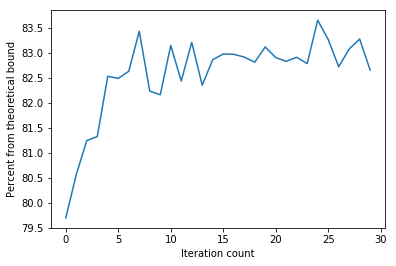

In [32]:
# Trying genetic search for x
np.random.seed(42)

# Setting parameters and creating the experiment
N = 4
repetitions = 10000
to_add = 10
to_keep = 5

# creating initial inputs
data = np.random.randn(to_keep, N)

# percents from theoretical bound
percents = []

maxiter = 30

for _ in range(maxiter):
  data_ = data

  # Randomizing inputs
  for input_ in data_:
    rand_direction = np.random.randn(to_add, N)
    rand_direction /= np.linalg.norm(rand_direction, axis = 0)
    rand_direction *= 0.5
    input_ = input_ + rand_direction
    data = np.vstack((data, input_))

  # Computing true values
  trues = [experiment.predict_no_dropout(value) for value in data]

  # Running the experiment
  errors = [experiment.get_error(value, repetitions = repetitions) for value in data]

  # List of errors for inputs
  error_array = np.mean(np.max(np.abs(errors), axis = 2), axis = 1)

  max_exp = np.max(error_array)
  
  # Choosing maximal error
  indices = np.argsort(-error_array)

  # Choosing best to_keep entries
  data = data[indices[:to_keep]]
  
  percent = 100 * max_exp / mean_bound
  print('Mean error %.5f, %.2f%% from theoretical, norm %.2f' % (max_exp, percent, np.linalg.norm(data.flatten()) / data.shape[0]))
  percents.append(percent)
  
plt.xlabel('Iteration count')
plt.ylabel('Percent from theoretical bound')
plt.plot(percents)
plt.show()

In [33]:
# Trying genetic search for x
np.random.seed(42)

mean_bound, std_bound = experiment.get_mean_std_error()

# creating initial inputs
data = np.random.randn(to_keep, N)

# percents from theoretical bound
percents_mean = []
percents_std = []

maxiter = 30

for _ in range(maxiter):
  data_ = data

  # Randomizing inputs
  for input_ in data_:
    rand_direction = np.random.randn(to_add, N)
    rand_direction /= np.linalg.norm(rand_direction, axis = 0)
    rand_direction *= 0.5
    input_ = input_ + rand_direction
    data = np.vstack((data, input_))

  # Computing true values
  trues = [experiment.predict_no_dropout(value) for value in data]

  # Running the experiment
  errors = [experiment.get_error(value, repetitions = repetitions) for value in data]

  # List of errors for inputs
  error_std_array  = np.std(np.max(np.abs(errors), axis = 2), axis = 1)
  error_mean_array = np.mean(np.max(np.abs(errors), axis = 2), axis = 1)

  max_std_exp = np.max(error_std_array)
  max_mean_exp = np.max(error_mean_array)
  
  # Choosing maximal error
  indices = np.argsort(-error_std_array)

  # Choosing best to_keep entries
  data = data[indices[:to_keep]]
  
  percent_mean = 100 * max_mean_exp / mean_bound
  percent_std = 100 * max_std_exp / std_bound
  print('Mean error %.5f, %.2f%% from theoretical, Std error %.5f, %.2f%% from theoretical, norm %.2f' % (
      max_mean_exp, percent_mean, max_std_exp, percent_std, np.linalg.norm(data.flatten()) / data.shape[0]))
  percents_mean.append(percent_mean)
  percents_std.append(percent_std)

Mean error 0.64204, 79.97% from theoretical, Std error 0.52893, 52.74% from theoretical, norm 0.81
Mean error 0.65061, 81.04% from theoretical, Std error 0.53804, 53.65% from theoretical, norm 0.87
Mean error 0.64984, 80.94% from theoretical, Std error 0.53821, 53.66% from theoretical, norm 0.92
Mean error 0.65590, 81.70% from theoretical, Std error 0.54233, 54.07% from theoretical, norm 1.10
Mean error 0.65835, 82.00% from theoretical, Std error 0.54207, 54.05% from theoretical, norm 1.17
Mean error 0.66021, 82.23% from theoretical, Std error 0.54523, 54.36% from theoretical, norm 1.21
Mean error 0.66535, 82.87% from theoretical, Std error 0.54756, 54.60% from theoretical, norm 1.31
Mean error 0.65735, 81.88% from theoretical, Std error 0.54440, 54.28% from theoretical, norm 1.33
Mean error 0.66383, 82.68% from theoretical, Std error 0.54725, 54.56% from theoretical, norm 1.39
Mean error 0.65998, 82.20% from theoretical, Std error 0.54689, 54.53% from theoretical, norm 1.49
Mean error

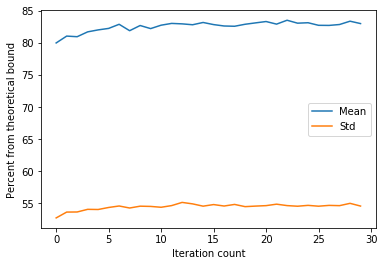

In [34]:
plt.xlabel('Iteration count')
plt.ylabel('Percent from theoretical bound')
plt.plot(percents_mean, label='Mean')
plt.plot(percents_std, label='Std')
plt.legend()
plt.show()

In [35]:
(std_bound ** 2 - mean_bound ** 2) ** 0.5 / std_bound

0.5993361702749445

In [ ]:
# why 104 instead of 100 and 92 instead of 90?